In [3]:
import os
import random
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet101, ResNet152, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2025-11-23 01:42:01.376586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 01:42:01.427109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 01:42:03.541054: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
DATA_DIR = "./1_Datasets"

In [5]:
import os, shutil
import numpy as np
from sklearn.model_selection import train_test_split

original_dataset_dir = f"{DATA_DIR}/GTSRB/Train"

# base_dir = '/kaggle/working/split_data'
base_dir = f"{DATA_DIR}/GTSRB/split_data"

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split each class
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path): continue

    images = os.listdir(class_path)
    train_files, temp_files = train_test_split(images, test_size=0.4, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    for subset_name, subset_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        subset_class_dir = os.path.join(base_dir, subset_name, class_name)
        os.makedirs(subset_class_dir, exist_ok=True)
        for fname in subset_files:
            src = os.path.join(class_path, fname)
            dst = os.path.join(subset_class_dir, fname)
            shutil.copy(src, dst)


In [6]:
IMG_SIZE = 224
batch_size = 32

In [7]:
def cnn_preprocess(x):
    return x/255.0

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cnn_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)

cnn_train_generator = cnn_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB/split_data/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

cnn_val_generator = cnn_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB/split_data/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

cnn_test_generator = cnn_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB/split_data/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 23525 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.


CNN

In [10]:


num_classes = len(cnn_val_generator.class_indices)

cnn_model = Sequential([
    InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(64, (3, 3), activation='relu', padding="same"),
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding="same"),
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding="same"),
    Conv2D(128, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax', dtype='float32')
])


In [11]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,763 (1.40 MB)

 Trainable params: 366,251 (1.40 MB)

 Non-trainable params: 512 (2.00 KB)

In [12]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=10,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [13]:
cnn_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy', 'precision', 'recall'])

In [14]:
cnn_history = cnn_model.fit(
        cnn_train_generator,
        epochs = 50,
        validation_data = cnn_val_generator,
        callbacks = callbacks
        )

Epoch 1/50


2025-11-23 01:44:05.273721: I external/local_xla/xla/service/service.cc:163] XLA service 0x76203c003640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-23 01:44:05.273753: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA H100 NVL, Compute Capability 9.0
2025-11-23 01:44:05.371606: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-23 01:44:05.758537: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-23 01:44:05.981374: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-23 01:44:05.981401: I external/

  5/736 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.0224 - loss: 3.8171 - precision: 0.0000e+00 - recall: 0.0000e+00  

I0000 00:00:1763862256.806400  717881 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 18/736 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.0328 - loss: 3.7930 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-11-23 01:44:18.322075: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2964', 8 bytes spill stores, 8 bytes spill loads



735/736 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1214 - loss: 3.2575 - precision: 0.3557 - recall: 0.0050

2025-11-23 01:44:54.137373: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-23 01:44:54.504391: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_248', 52 bytes spill stores, 52 bytes spill loads

2025-11-23 01:44:54.575960: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_248', 88 bytes spill stores, 88 bytes spill loads

2025-11-23 01:44:54.644461: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_248', 84 bytes


Epoch 1: val_loss improved from None to 2.84048, saving model to CNN_best_model.keras
736/736 ━━━━━━━━━━━━━━━━━━━━ 65s 71ms/step - accuracy: 0.1561 - loss: 3.0374 - precision: 0.5379 - recall: 0.0130 - val_accuracy: 0.1835 - val_loss: 2.8405 - val_precision: 0.5371 - val_recall: 0.0240
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2039 - loss: 2.7315 - precision: 0.5926 - recall: 0.0343
Epoch 2: val_loss improved from 2.84048 to 2.69128, saving model to CNN_best_model.keras
736/736 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.2212 - loss: 2.6540 - precision: 0.6275 - recall: 0.0440 - val_accuracy: 0.2184 - val_loss: 2.6913 - val_precision: 0.5759 - val_recall: 0.0769
Epoch 3/50
735/736 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2780 - loss: 2.3828 - precision: 0.7004 - recall: 0.0781
Epoch 3: val_loss improved from 2.69128 to 2.13703, saving model to CNN_best_model.keras
736/736 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.2951 - loss: 2.3036 - precis

In [16]:
test_loss, test_accuracy, test_precision, test_recall = cnn_model.evaluate(cnn_test_generator)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)


  1/246 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 1.0000 - loss: 0.0093 - precision: 1.0000 - recall: 1.0000

246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9915 - loss: 0.0313 - precision: 0.9926 - recall: 0.9906
Test Accuracy: 0.9914562702178955
Test Loss: 0.03129187598824501


In [17]:
import pandas as pd
results = cnn_model.evaluate(cnn_test_generator)
metric_names = cnn_model.metrics_names

print(metric_names)
print(results)

metrics_dict = {name: [value] for name, value in zip(metric_names, results)}
df = pd.DataFrame(metrics_dict)

# df.to_csv("test_metrics.csv", index=False)


246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9915 - loss: 0.0313 - precision: 0.9926 - recall: 0.9906
['loss', 'compile_metrics']
[0.03129187598824501, 0.9914562702178955, 0.9925888180732727, 0.9905636310577393]


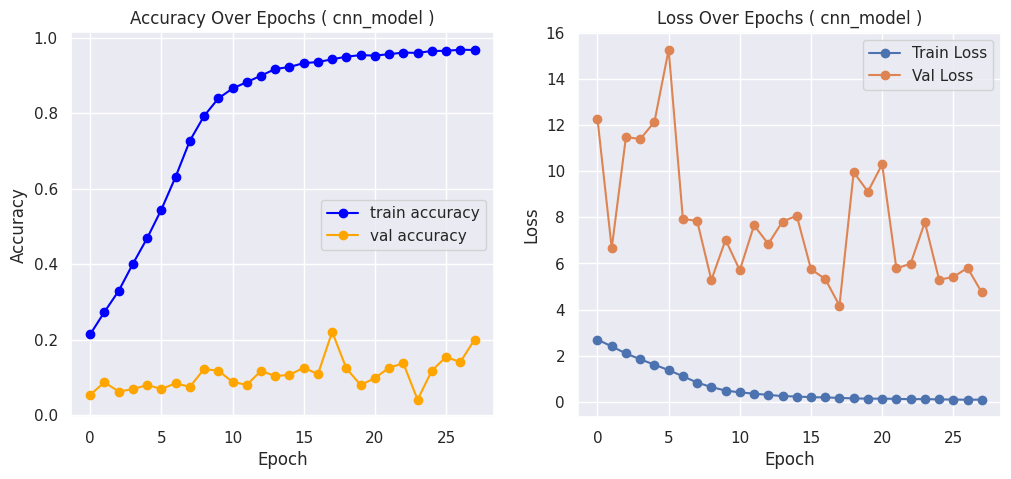

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(cnn_history.history['accuracy'],label='train accuracy',marker='o',color='blue')
plt.plot(cnn_history.history['val_accuracy'],label='val accuracy',marker='o',color='orange')
plt.title('Accuracy Over Epochs ( cnn_model )')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs ( cnn_model )')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


VGG16

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

vgg_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)

vgg_train_generator = vgg_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB/split_data/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

vgg_val_generator = vgg_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB_glare/split_data/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

vgg_test_generator = vgg_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB_glare/split_data/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 23525 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.


In [17]:
vgg_traind_layer=VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

In [18]:
for layer in vgg_traind_layer.layers:
    layer.trainable=False

In [19]:
VGG_model=Sequential([
   vgg_traind_layer,
   Flatten(),
   Dense(units=256,activation='relu'),
   Dense(units=len(vgg_val_generator.class_indices),activation='softmax')
    
])

In [20]:
VGG_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,148,523 (80.68 MB)

 Trainable params: 6,433,835 (24.54 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=10,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='VGG_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [22]:
VGG_model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
               metrics=['accuracy','precision', 'recall'])


In [23]:
VGG_history = VGG_model.fit(
        vgg_train_generator,
        epochs = 50,
        validation_data = vgg_val_generator,
        callbacks = callbacks
        )

Epoch 1/50


2025-11-22 22:03:08.051791: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-22 22:03:08.051843: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-22 22:03:08.051858: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-22 22:03:08.405858: I external/l

735/736 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4958 - loss: 1.9485 - precision: 0.8698 - recall: 0.3222
Epoch 1: val_loss improved from None to 2.77756, saving model to VGG_best_model.keras
736/736 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.6398 - loss: 1.3109 - precision: 0.9164 - recall: 0.4837 - val_accuracy: 0.4075 - val_loss: 2.7776 - val_precision: 0.4401 - val_recall: 0.3366
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8303 - loss: 0.5777 - precision: 0.9454 - recall: 0.7378
Epoch 2: val_loss improved from 2.77756 to 2.40682, saving model to VGG_best_model.keras
736/736 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.8428 - loss: 0.5302 - precision: 0.9439 - recall: 0.7627 - val_accuracy: 0.4945 - val_loss: 2.4068 - val_precision: 0.5753 - val_recall: 0.4426
Epoch 3/50
735/736 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8962 - loss: 0.3546 - precision: 0.9612 - recall: 0.8402
Epoch 3: val_loss improved from 2.40682 to 2.23670, saving mod

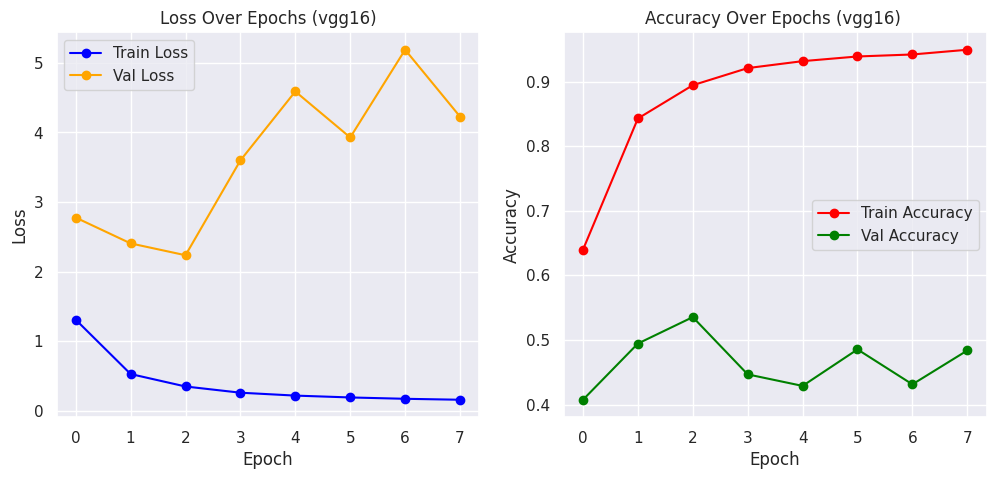

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(VGG_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(VGG_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs (vgg16)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(VGG_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(VGG_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs (vgg16) ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Inception

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Inception_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)

Inception_train_generator = Inception_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB/split_data/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

Inception_val_generator = Inception_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB_glare/split_data/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

Inception_test_generator = Inception_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB_glare/split_data/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 23525 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.


In [26]:
from tensorflow.keras.applications import InceptionV3
trained_Inception_layers = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

In [27]:
for layer in trained_Inception_layers.layers:
    layer.trainable = False

In [28]:
Inception_model = Sequential([
    trained_Inception_layers,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(len(Inception_val_generator.class_indices), activation='softmax')
])

In [29]:
Inception_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,338,379 (85.21 MB)

 Trainable params: 535,595 (2.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [30]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='Inception_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    )
]

In [31]:
Inception_model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
               metrics=['accuracy','precision', 'recall'])


In [32]:
Inception_history = Inception_model.fit(
    Inception_train_generator,
    epochs=50,
    validation_data=Inception_val_generator,
    callbacks=callbacks
)

Epoch 1/50


2025-11-22 22:13:50.425546: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


736/736 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5962 - loss: 1.4513 - precision: 0.8379 - recall: 0.4380
Epoch 1: val_loss improved from None to 2.80921, saving model to Inception_best_model.keras
736/736 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.7155 - loss: 0.9564 - precision: 0.8668 - recall: 0.6012 - val_accuracy: 0.3520 - val_loss: 2.8092 - val_precision: 0.4531 - val_recall: 0.2808
Epoch 2/50
735/736 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8559 - loss: 0.4422 - precision: 0.9079 - recall: 0.8037
Epoch 2: val_loss did not improve from 2.80921
736/736 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.8669 - loss: 0.4106 - precision: 0.9138 - recall: 0.8221 - val_accuracy: 0.3481 - val_loss: 3.3808 - val_precision: 0.4074 - val_recall: 0.3111
Epoch 3/50
735/736 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9097 - loss: 0.2799 - precision: 0.9372 - recall: 0.8814
Epoch 3: val_loss did not improve from 2.80921
736/736 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accura

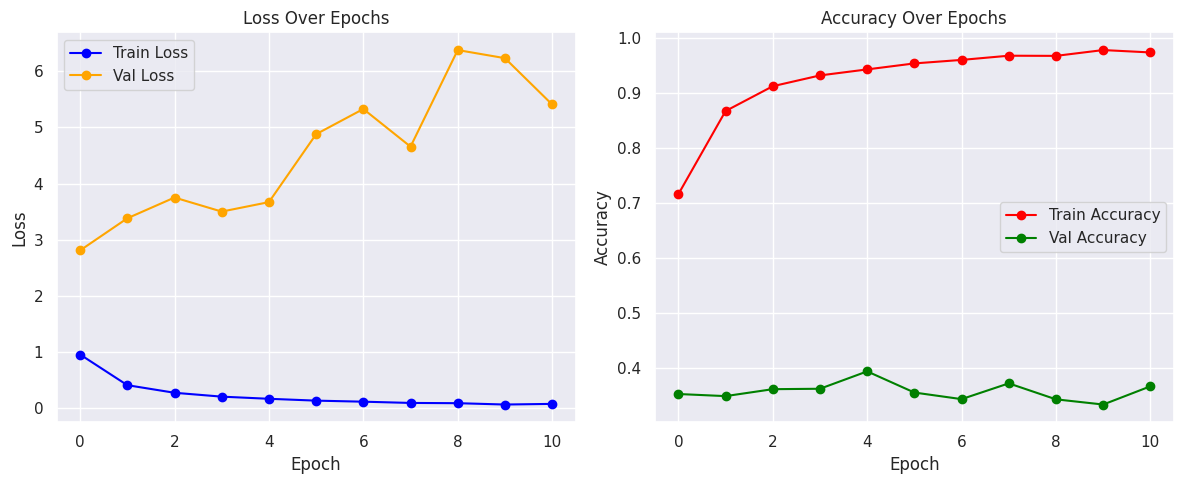

In [33]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(Inception_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(Inception_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(Inception_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(Inception_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

resnet50v2

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ResNet_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)

ResNet_train_generator = ResNet_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB/split_data/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

ResNet_val_generator = ResNet_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB_glare/split_data/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

ResNet_test_generator = ResNet_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB_glare/split_data/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 23525 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.


In [35]:
trained_ResNet_layers = ResNet50V2(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

In [36]:
for layer in trained_ResNet_layers.layers:
    layer.trainable = False


In [37]:
ResNet_model = Sequential([
    trained_ResNet_layers,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(len(ResNet_val_generator.class_indices), activation='softmax')
]) 

In [38]:
ResNet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,100,395 (91.94 MB)

 Trainable params: 535,595 (2.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [39]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=10,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='ResNet_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [40]:
ResNet_model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
               metrics=['accuracy','precision', 'recall'])


In [41]:
ResNet_history = ResNet_model.fit(
        ResNet_train_generator,
        epochs = 50,
        validation_data = ResNet_val_generator,
        callbacks = callbacks
        )

Epoch 1/50


736/736 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6544 - loss: 1.2006 - precision: 0.8709 - recall: 0.5147
Epoch 1: val_loss improved from None to 2.55503, saving model to ResNet_best_model.keras
736/736 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - accuracy: 0.7777 - loss: 0.7244 - precision: 0.8914 - recall: 0.6854 - val_accuracy: 0.4137 - val_loss: 2.5550 - val_precision: 0.5364 - val_recall: 0.3551
Epoch 2/50
735/736 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9093 - loss: 0.2701 - precision: 0.9388 - recall: 0.8838
Epoch 2: val_loss did not improve from 2.55503
736/736 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.9157 - loss: 0.2535 - precision: 0.9394 - recall: 0.8929 - val_accuracy: 0.4342 - val_loss: 2.9446 - val_precision: 0.5037 - val_recall: 0.3994
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9534 - loss: 0.1460 - precision: 0.9646 - recall: 0.9415
Epoch 3: val_loss did not improve from 2.55503
736/736 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy:

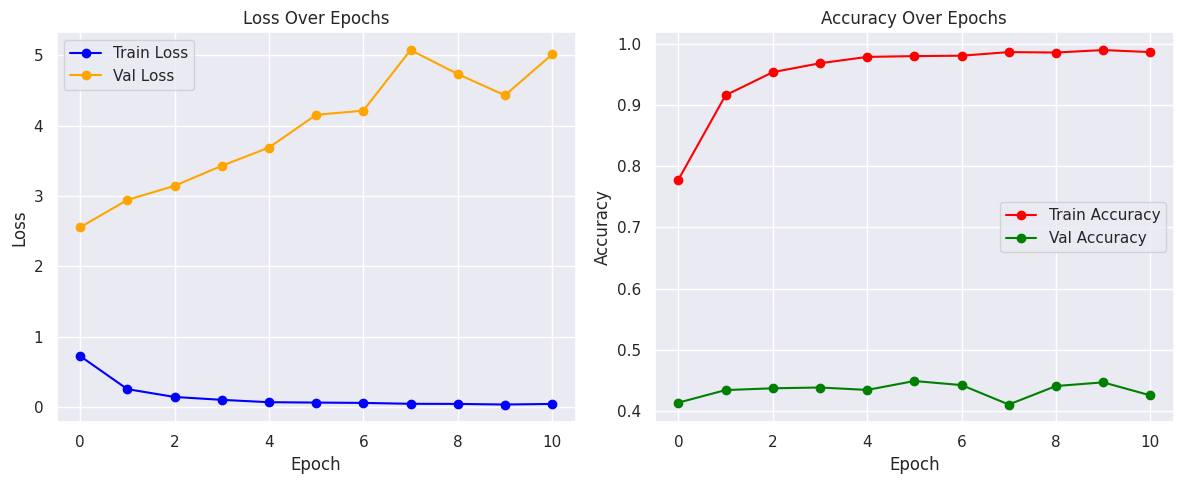

In [42]:
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(ResNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(ResNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(ResNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(ResNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

mobilenetv2

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Mobile_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)

Mobile_train_generator = Mobile_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB/split_data/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

Mobile_val_generator = Mobile_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB_glare/split_data/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

Mobile_test_generator = Mobile_datagen.flow_from_directory(
    f"{DATA_DIR}/GTSRB_glare/split_data/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 23525 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.


In [44]:
trained_mobile_layers = ResNet50V2(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

In [45]:
for layer in trained_mobile_layers.layers:
    layer.trainable = False


In [46]:
mobile_model = Sequential([
    trained_ResNet_layers,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(len(Mobile_val_generator.class_indices), activation='softmax')
]) 

In [47]:
mobile_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,100,395 (91.94 MB)

 Trainable params: 535,595 (2.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [48]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=10,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='mobile_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [49]:
ResNet_model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
               metrics=['accuracy','precision', 'recall'])


In [50]:
mobile_history = ResNet_model.fit(
        Mobile_train_generator,
        epochs = 50,
        validation_data = Mobile_val_generator,
        callbacks = callbacks
        )

Epoch 1/50


735/736 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8993 - loss: 0.3005 - precision: 0.9293 - recall: 0.8715
Epoch 1: val_loss improved from None to 3.11958, saving model to mobile_best_model.keras
736/736 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - accuracy: 0.9108 - loss: 0.2664 - precision: 0.9358 - recall: 0.8886 - val_accuracy: 0.4366 - val_loss: 3.1196 - val_precision: 0.5042 - val_recall: 0.4018
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9538 - loss: 0.1422 - precision: 0.9657 - recall: 0.9420
Epoch 2: val_loss did not improve from 3.11958
736/736 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.9537 - loss: 0.1402 - precision: 0.9636 - recall: 0.9441 - val_accuracy: 0.4045 - val_loss: 3.6649 - val_precision: 0.4513 - val_recall: 0.3832
Epoch 3/50
735/736 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9662 - loss: 0.1071 - precision: 0.9733 - recall: 0.9591
Epoch 3: val_loss did not improve from 3.11958
736/736 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy:

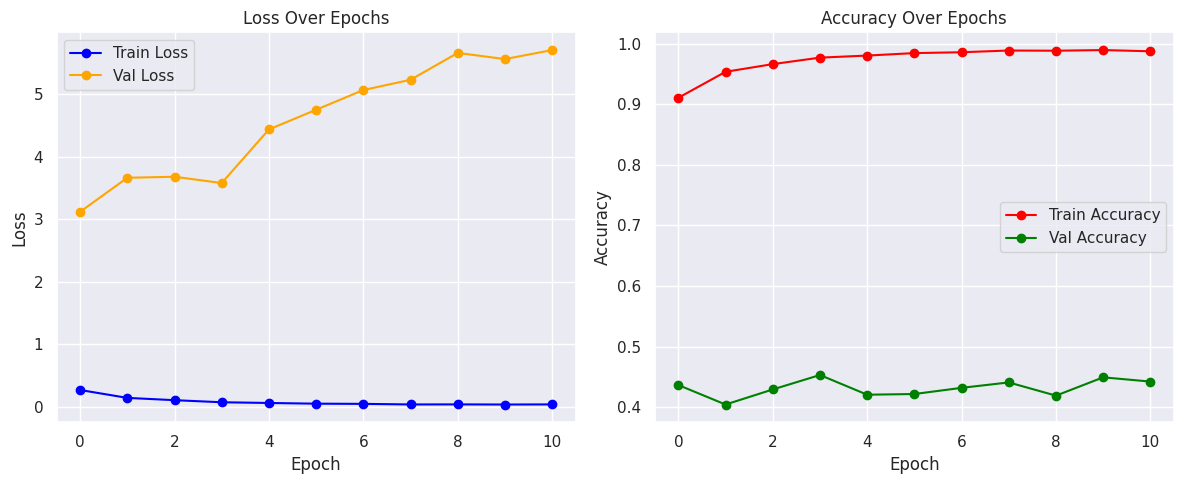

In [51]:
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(mobile_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(mobile_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(mobile_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(mobile_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [52]:
history = {
    "CNN": {
        "accuracy": cnn_history.history['accuracy'],
        "val_accuracy": cnn_history.history['val_accuracy'],
        "loss": cnn_history.history['loss'],
        "val_loss": cnn_history.history['val_loss']
    },
    "VGG16": {
        "accuracy": VGG_history.history['accuracy'],
        "val_accuracy": VGG_history.history['val_accuracy'],
        "loss": VGG_history.history['loss'],
        "val_loss": VGG_history.history['val_loss']
    },
    "Inception": {
        "accuracy": Inception_history.history['accuracy'],
        "val_accuracy": Inception_history.history['val_accuracy'],
        "loss": Inception_history.history['loss'],
        "val_loss": Inception_history.history['val_loss']
    },
    "ResNet50V2": {
        "accuracy": ResNet_history.history['accuracy'],
        "val_accuracy": ResNet_history.history['val_accuracy'],
        "loss": ResNet_history.history['loss'],
        "val_loss": ResNet_history.history['val_loss']
    },
    "MobileNetV2": {
        "accuracy": mobile_history.history['accuracy'],
        "val_accuracy": mobile_history.history['val_accuracy'],
        "loss": mobile_history.history['loss'],
        "val_loss": mobile_history.history['val_loss']
    }
}


In [ ]:


results = []

for name, hist in history.items():
    epochs = range(1, len(hist['accuracy']) + 1)

    df_model = pd.DataFrame({
        "model": name,
        "epoch": epochs,
        "accuracy": hist.get("accuracy"),
        "val_accuracy": hist.get("val_accuracy"),
        "loss": hist.get("loss"),
        "val_loss": hist.get("val_loss"),
        "precision": hist.get("precision"),
        "val_precision": hist.get("val_precision"),
        "recall": hist.get("recall"),
        "val_recall": hist.get("val_recall"),
    })

    results.append(df_model)

df_all = pd.concat(results, ignore_index=True)
df_all.to_csv("./Results/csv/normal/model_training_metrics_train_normal_val_test_glare.csv", index=False)


: 

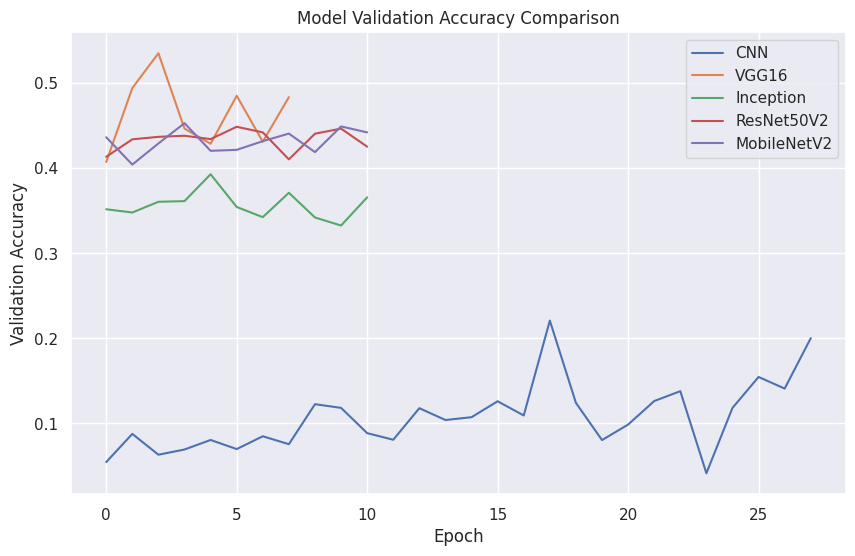

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_accuracy'], label=model)
plt.title('Model Validation Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.savefig("./Results/figures/normal/acc_comparison_train_normal_test_val_glare.png")
plt.show()

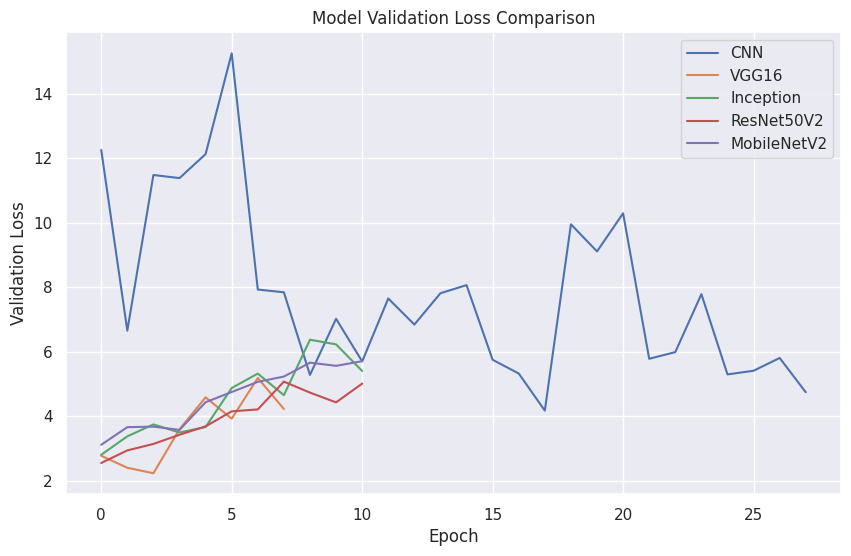

In [55]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_loss'], label=model)
plt.title('Model Validation Loss Comparison')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.savefig("./Results/figures/normal/val_loss_comparison_train_normal_val_test_glare.png")
plt.show()


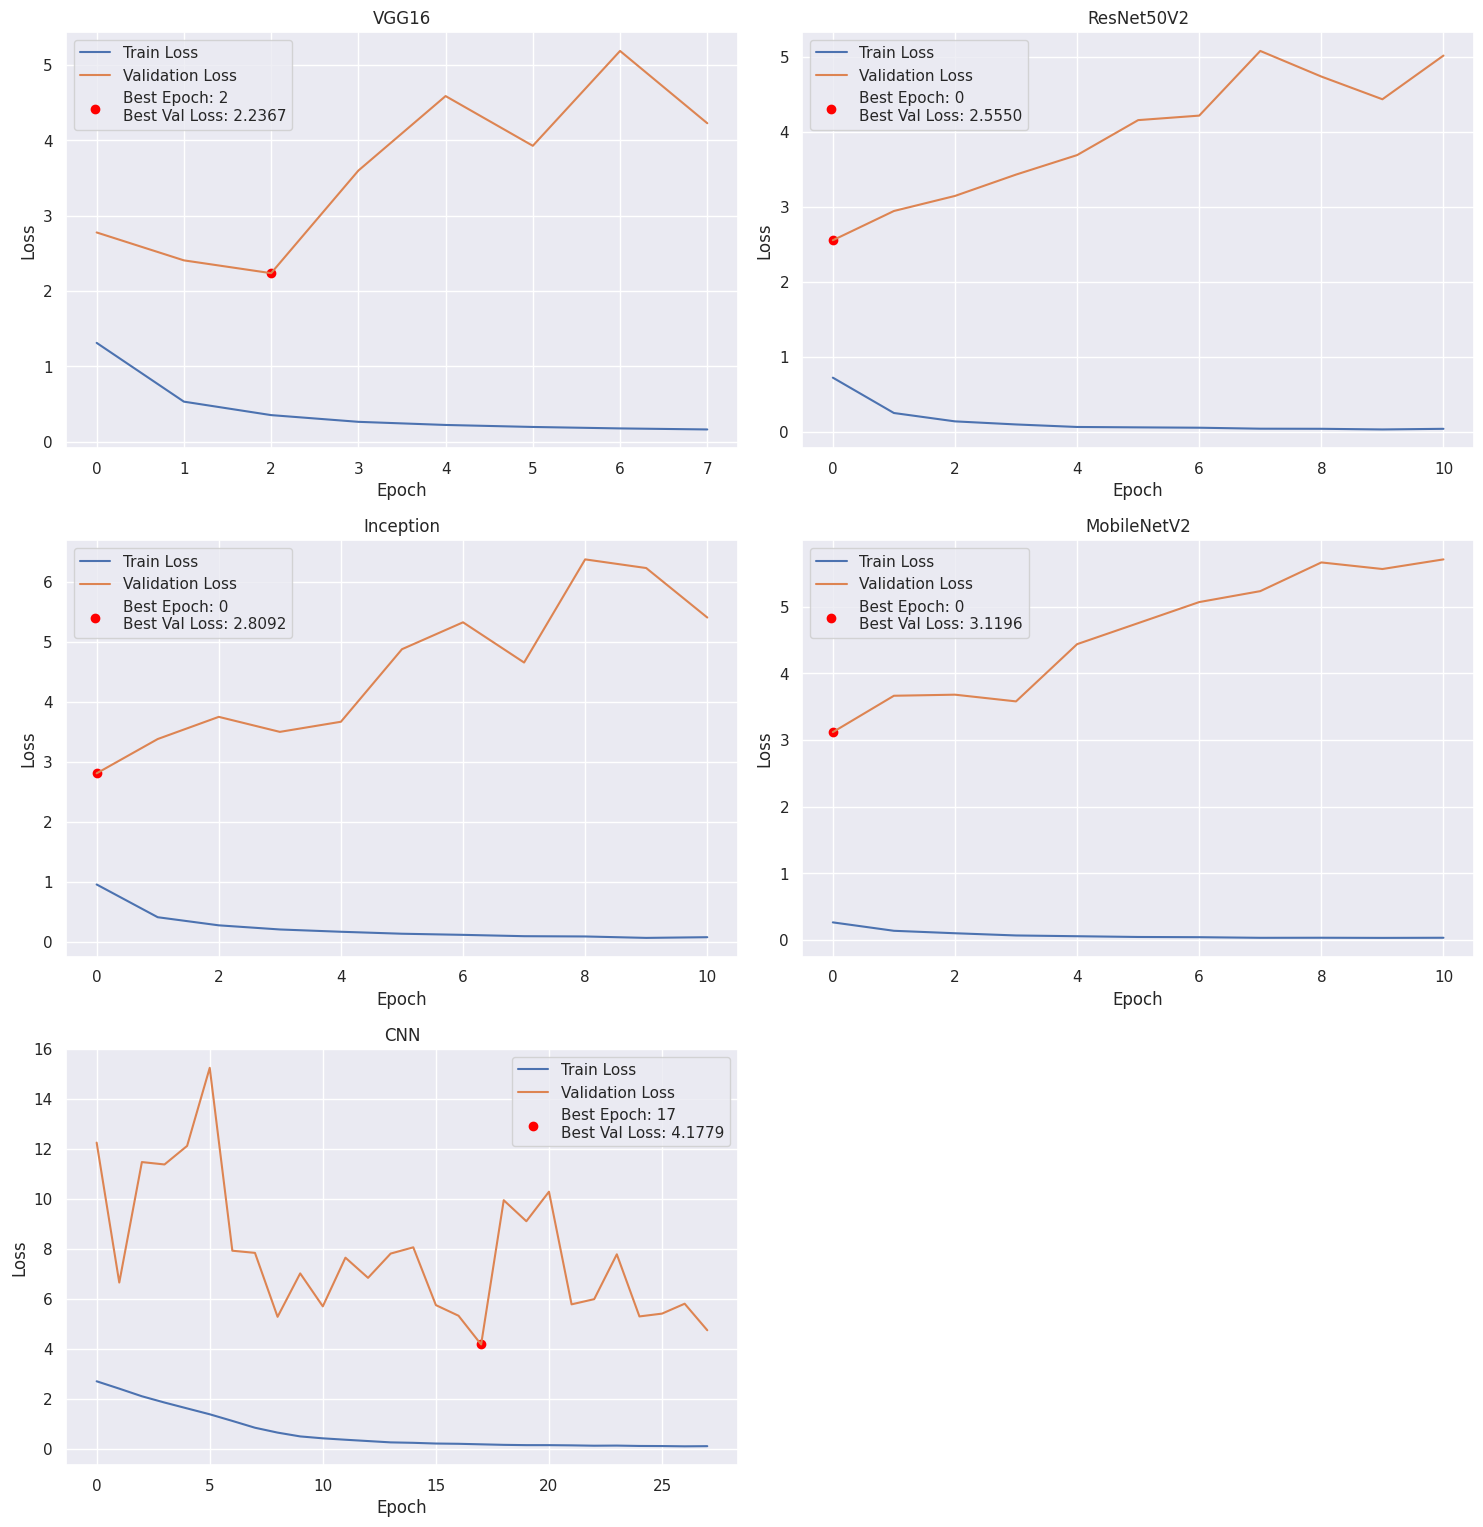

In [56]:
plt.figure(figsize=(15, 20))

sorted_models = sorted(history.items(), key=lambda x: min(x[1]['val_loss']))

for i, (model_name, model_history) in enumerate(sorted_models, 1):
    plt.subplot(4, 2, i) 
    plt.plot(model_history['loss'], label='Train Loss')
    plt.plot(model_history['val_loss'], label='Validation Loss')

    
    min_val_loss_epoch = model_history['val_loss'].index(min(model_history['val_loss']))
    min_val_loss = min(model_history['val_loss'])

    plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Best Epoch: {min_val_loss_epoch}\nBest Val Loss: {min_val_loss:.4f}')

    plt.title(model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.savefig("./Results/figures/normal/all_models_train_normal_test_val_glare.png")
plt.show()


In [57]:
models = ['Best CNN','Best MobileNetV2','Best VGG16','Best Inception','Best ResNest50']
best_train_accuracy= [
                        cnn_history.history['accuracy'][np.argmax(cnn_history.history['accuracy'])],
                        mobile_history.history['accuracy'][np.argmax(mobile_history.history['accuracy'])],
                        VGG_history.history['accuracy'][np.argmax(VGG_history.history['accuracy'])],
                        Inception_history.history['accuracy'][np.argmax(Inception_history.history['accuracy'])],
                        ResNet_history.history['accuracy'][np.argmax(ResNet_history.history['accuracy'])]
                     ]
best_val_accuracy= [
                        cnn_history.history['val_accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
                        mobile_history.history['val_accuracy'][np.argmax(mobile_history.history['val_accuracy'])],
                        VGG_history.history['val_accuracy'][np.argmax(VGG_history.history['val_accuracy'])],
                        Inception_history.history['val_accuracy'][np.argmax(Inception_history.history['val_accuracy'])],
                        ResNet_history.history['val_accuracy'][np.argmax(ResNet_history.history['val_accuracy'])]
                     ]

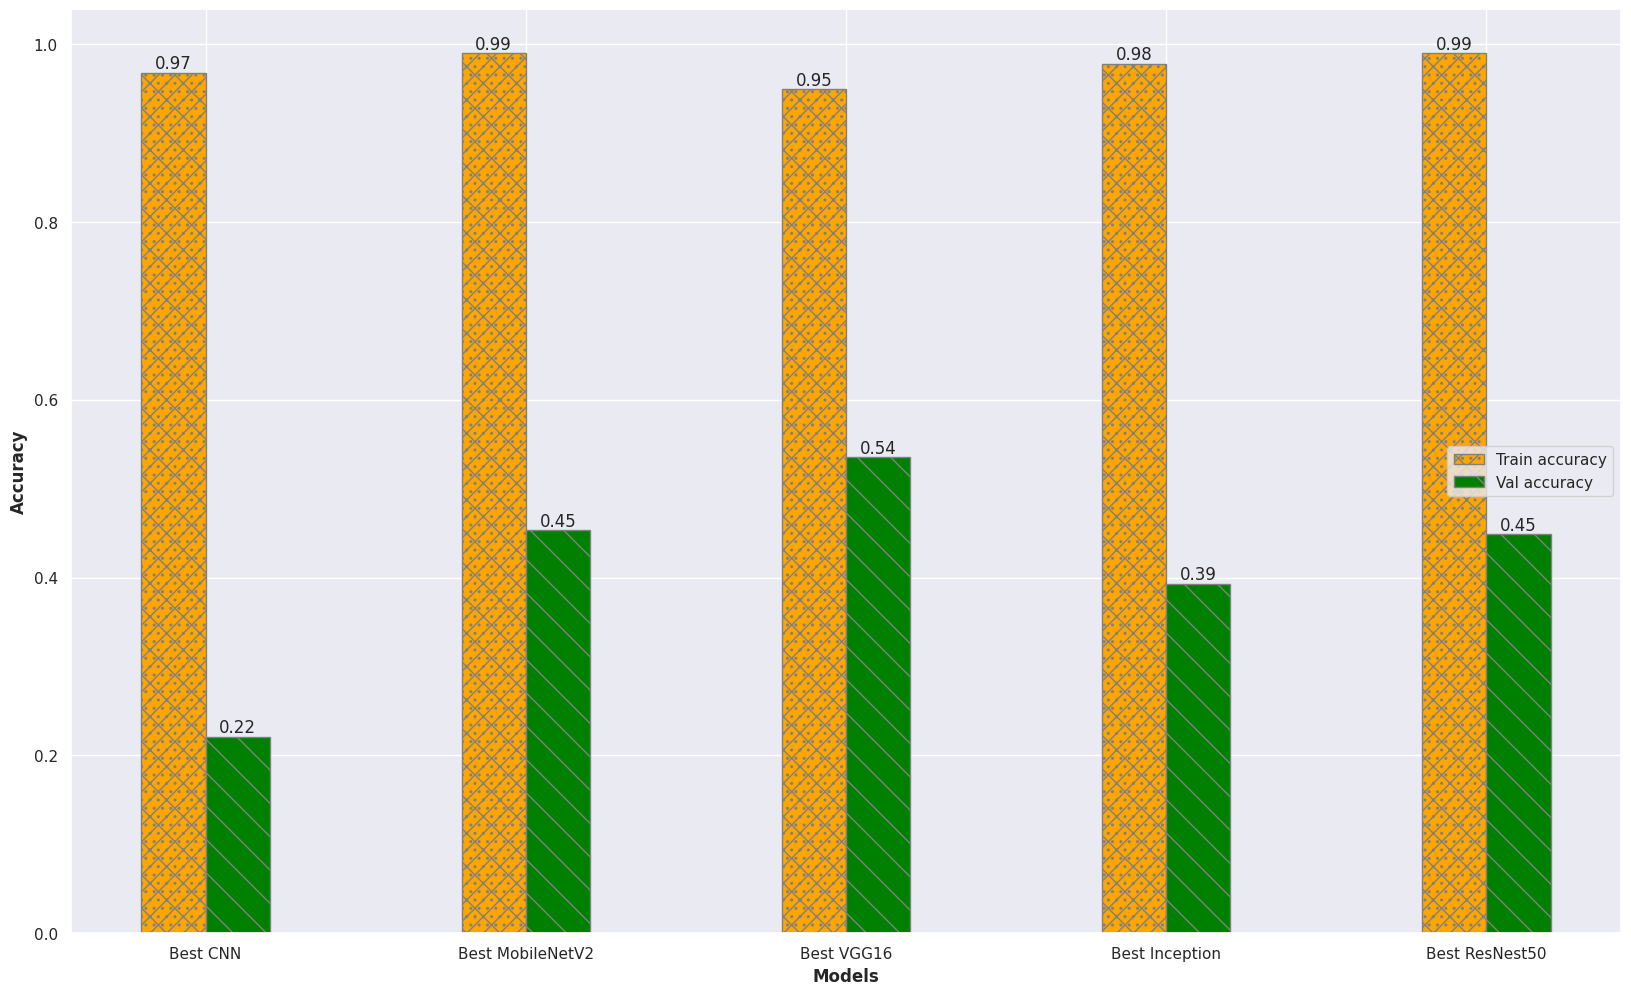

In [62]:
barWidth = 0.20

r1 = np.arange(len(best_train_accuracy))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(20, 12))
bars1 = plt.bar(r1, best_train_accuracy, color='orange', width=barWidth, edgecolor='grey', label='Train accuracy', hatch = "//\..")
bars2 = plt.bar(r2, best_val_accuracy, color='green', width=barWidth, edgecolor='grey', label='Val accuracy', hatch = "\\")

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(best_train_accuracy))], models)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.legend(loc='center right')
plt.savefig("./Results/figures/normal/all_models_train_val_acc_comparison_train_normal_test_val_glare.png")
plt.show()

In [152]:

histories = {
    'CNN': cnn_history,
    'MobileNet': mobile_history,
    'VGG': VGG_history,
    'Inception': Inception_history,
    'ResNet': ResNet_history
}


ACCURACY_GAP_THRESHOLD = 0.1  #  10% gap --> Overfitting
LOSS_GAP_THRESHOLD = 0.5      # 50 % gap --> Overfitting


overfitting_results = []


for model_name, history in histories.items():
    
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    
    
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    
    acc_gap = final_train_acc - final_val_acc
    loss_gap = final_val_loss - final_train_loss
    
    
    is_overfitting = False
    if acc_gap > ACCURACY_GAP_THRESHOLD or loss_gap > LOSS_GAP_THRESHOLD:
        is_overfitting = True
    
    
    overfitting_results.append({
        'Model': model_name,
        'Accuracy_Gap': acc_gap,
        'Loss_Gap': loss_gap,
        'Overfitting': 'Yes' if is_overfitting else 'No'
    })


overfitting_df = pd.DataFrame(overfitting_results)


print("\nOverfitting Analysis:")
print(overfitting_df[['Model', 'Accuracy_Gap','Loss_Gap', 'Overfitting']])


overfitting_models = overfitting_df[overfitting_df['Overfitting'] == 'Yes']['Model'].tolist()
if overfitting_models:
    print(f"\nModels showing overfitting: {', '.join(overfitting_models)}")
else:
    print("\nNo models show significant overfitting.")


Overfitting Analysis:
       Model  Accuracy_Gap  Loss_Gap Overfitting
0        CNN      0.096785  0.478084          No
1  MobileNet      0.031624  0.147241          No
2        VGG      0.053896  0.206266          No
3  Inception      0.067159  0.283906          No
4     ResNet      0.044079  0.176977          No

No models show significant overfitting.
